# PDBe API Training

### PDBe Ligand Interactions for a given protein

This tutorial will guide you through searching PDBe programmatically.


First we will import the code which will do the work
Run the cell below - by pressing the green play button.

In [1]:
import pandas as pd
import numpy as np
import requests
from pprint import pprint
import matplotlib.pyplot as plt
from IPython.display import SVG, display
import sys
sys.path.insert(0,'..')
from python_modules.api_modules import explode_dataset, get_ligand_site_data, get_similar_ligand_data

Now we are ready to find all the ligands and its interaction details bound to a given protein.

We will get ligands for the Human Acetylcholinesterase, which has the UniProt accession P22303 

In [2]:
uniprot_accession = 'P22303'

uniprot_accession

'P22303'

Get compounds which interact with the UniProt

In [3]:
ligand_data = get_ligand_site_data(uniprot_accession=uniprot_accession)

https://www.ebi.ac.uk/pdbe/graph-api/uniprot/ligand_sites/P22303


In [4]:
#pprint(ligand_data)

In [5]:
df2 = explode_dataset(result=ligand_data, column_to_explode='interactingPDBEntries')

Some post processing is required to separating interactingPDBEntries into separate columns

In [6]:
print(df2.head())

   startIndex  endIndex startCode endCode indexType   
0         113       113       GLY     GLY   UNIPROT  \
1         114       114       THR     THR   UNIPROT   
2         117       117       TRP     TRP   UNIPROT   
3         233       233       GLU     GLU   UNIPROT   
4         368       368       TYR     TYR   UNIPROT   

                               interactingPDBEntries allPDBEntries   
0  {'pdbId': '7xn1', 'entityId': 1, 'chainIds': 'A'}        [7xn1]  \
1  {'pdbId': '7xn1', 'entityId': 1, 'chainIds': 'A'}        [7xn1]   
2  {'pdbId': '7xn1', 'entityId': 1, 'chainIds': 'A'}        [7xn1]   
3  {'pdbId': '7xn1', 'entityId': 1, 'chainIds': 'A'}        [7xn1]   
4  {'pdbId': '7xn1', 'entityId': 1, 'chainIds': 'A'}        [7xn1]   

  ligand_accession ligand_name  ligand_num_atoms uniprot_accession   
0              THA     TACRINE                15            P22303  \
1              THA     TACRINE                15            P22303   
2              THA     TACRINE        

In [7]:
data = pd.json_normalize(df2['interactingPDBEntries'])
df3 = df2.join(data).drop(columns='interactingPDBEntries')


startIndex and endIndex are the UniProt residue number, so we'll make a new column called residue_number
and copy the startIndex there.
We are also going to "count" the number of results - so we'll make a dummy count column to store it in

In [8]:
df3['residue_number'] = df3['startIndex']
df3['count'] = df3['pdbId']

Now we are ready to use the data.

In [9]:
df3.head()

,startIndex,endIndex,startCode,endCode,indexType,allPDBEntries,ligand_accession,ligand_name,ligand_num_atoms,uniprot_accession,interaction_ratio,pdbId,entityId,chainIds,residue_number,count
0,113,113,GLY,GLY,UNIPROT,[7xn1],THA,TACRINE,15,P22303,1.0,7xn1,1,A,113,7xn1
1,114,114,THR,THR,UNIPROT,[7xn1],THA,TACRINE,15,P22303,1.0,7xn1,1,A,114,7xn1
2,117,117,TRP,TRP,UNIPROT,[7xn1],THA,TACRINE,15,P22303,1.0,7xn1,1,A,117,7xn1
3,233,233,GLU,GLU,UNIPROT,[7xn1],THA,TACRINE,15,P22303,1.0,7xn1,1,A,233,7xn1
4,368,368,TYR,TYR,UNIPROT,[7xn1],THA,TACRINE,15,P22303,1.0,7xn1,1,A,368,7xn1


Ligands which interact with every entry have an interaction_ratio of 1.0.
So lets get them....

In [10]:
df4 = df3.groupby('ligand_accession')['interaction_ratio'].mean().reset_index()
ret = df4.query('interaction_ratio == 1.0')['ligand_accession'].values

In [11]:
ret

array(['1PE', '1YK', '1YL', '4IX', '4J1', 'AA', 'BR', 'CVZ', 'E20', 'EBW',
       'FP1', 'FUL', 'GAL', 'GD8', 'GNT', 'H0L', 'H0R', 'H1R', 'HLO',
       'HUP', 'HUW', 'L0S', 'L1M', 'PEG', 'PQY', 'QRH', 'THA', 'WW2'],
      dtype=object)

Lets see if we can filter ligands by which ligands interact with the residues which have the most interactions.

First lets see how many interactions we have per residue.

In [12]:
df4 = df3.groupby('residue_number')['count'].count().reset_index()

<Axes: xlabel='residue_number', ylabel='count'>

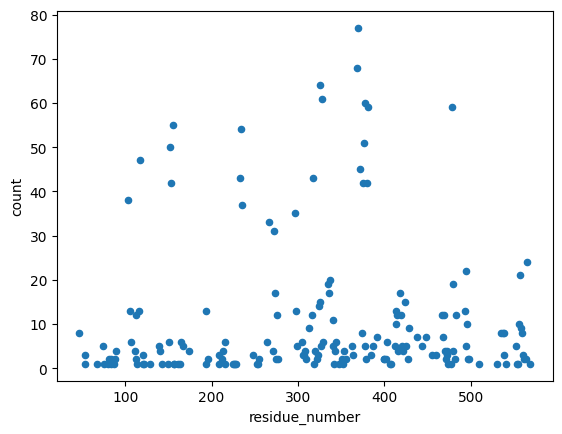

In [13]:
df4.plot.scatter(x='residue_number', y='count')

We can the determine the mean number of interactions and the standard deviation

In [14]:
mean = df4.mean()
std = df4.std()
print("Mean:")
print(mean)
print("Standard deviation:")
print(std)

Mean:
residue_number    322.565934
count              10.945055
dtype: float64
Standard deviation:
residue_number    144.868634
count              15.981593
dtype: float64


We need to extract the standard deviation value as a number from the above result

In [15]:
mean_value = float(mean.values[1])
std_value = float(std.values[1])
print(mean_value, std_value)

10.945054945054945 15.9815934437868


Then we can plot residues which have more interactions than the mean in red
and those which are equal to or below in blue.

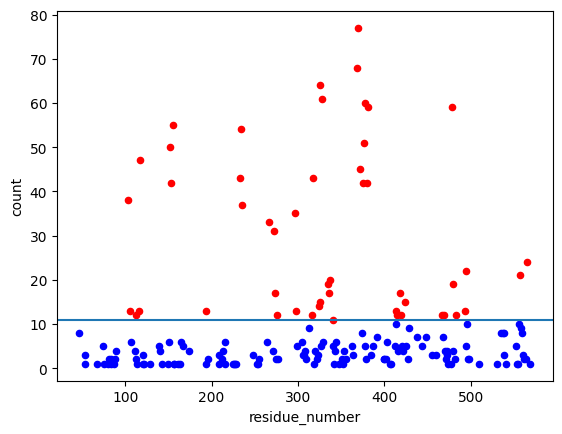

In [16]:
fig, ax = plt.subplots() # this makes one plot with an axis "ax" which we can add several plots to
df4.query('count <= {}'.format(mean_value)).plot.scatter(x='residue_number', y='count', color='blue', ax=ax)
df4.query('count > {}'.format(mean_value)).plot.scatter(x='residue_number', y='count', color='red', ax=ax)
ax.axhline(mean_value)
plt.show()
plt.close()

A higher threshold (two standard deviations) would be more useful to select only the most common ligand-binding residues

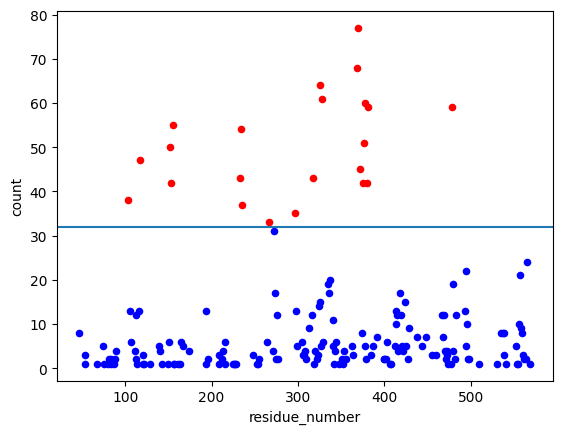

In [17]:
two_std_value = std_value * 2
fig, ax = plt.subplots() # this makes one plot with an axis "ax" which we can add several plots to
df4.query('count <= {}'.format(two_std_value)).plot.scatter(x='residue_number', y='count', color='blue', ax=ax)
df4.query('count > {}'.format(two_std_value)).plot.scatter(x='residue_number', y='count', color='red', ax=ax)
ax.axhline(two_std_value)
plt.show()
plt.close()


The actual residues are

In [18]:
all_data_over_two_std = df4.query('count > {}'.format(two_std_value))
all_data_over_two_std


,residue_number,count
13,103,38
21,117,47
31,152,50
32,153,42
33,155,55
54,233,43
55,234,54
56,235,37
62,267,33
69,296,35


we only want the residue numbers for the next step

In [19]:
residue_numbers_over_two_std = all_data_over_two_std['residue_number']
residue_numbers_over_two_std

13     103
21     117
31     152
32     153
33     155
54     233
55     234
56     235
62     267
69     296
79     317
86     326
88     328
105    368
106    369
107    372
109    375
110    376
112    378
114    380
115    381
152    478
Name: residue_number, dtype: int64

What ligands interact with these residues?

Now we want to get all ligand_accessions which interact with a residue in "residue_numbers_over_two_std"

In [20]:
df5  = df3[df3['residue_number'].isin(residue_numbers_over_two_std)]['ligand_accession']
df5

2       THA
3       THA
4       THA
5       THA
7       THA
       ... 
1919     CL
1920     CL
1921     CL
1922     CL
1923     CL
Name: ligand_accession, Length: 1105, dtype: object

The same ligand appears several times so we an "unique" the list to get our list of ligands
which have a number of interactions over the mean interaction count.

In [21]:
interesting_ligands = list(df5.unique())
interesting_ligands

['THA',
 'AA',
 '4IX',
 '4J1',
 '3VI',
 'HLO',
 'HI6',
 'LND',
 'CVZ',
 'E20',
 'H0R',
 'H1R',
 'H0L',
 '1YK',
 '1YL',
 'EBW',
 'QRH',
 'FP1',
 'HUP',
 'MES',
 'PQY',
 'FUL',
 'FUC',
 'NAG',
 'PQV',
 'WW2',
 'UCY',
 'GNT',
 'HUW',
 'GOL',
 'EFS',
 'ELT',
 'NWA',
 'GD8',
 'UCJ',
 'DMS',
 'DEP',
 'L2Y',
 'L0S',
 'L1M',
 'VX',
 'SO4',
 'CL']

It's worth seeing which ligands are not in our list

In [22]:
all_ligands = list(df3['ligand_accession'].unique())

missing_ligands = [x for x in all_ligands if x not in interesting_ligands]
missing_ligands

['GAL', 'SIA', 'BR', '1PE', 'MG', 'PE8', '7PE', 'PEG', 'EDO', 'NO3']

Now we can display the interactions only for those ligands we have found

We will start with our Dataframe df3

In [23]:
df3.head()

,startIndex,endIndex,startCode,endCode,indexType,allPDBEntries,ligand_accession,ligand_name,ligand_num_atoms,uniprot_accession,interaction_ratio,pdbId,entityId,chainIds,residue_number,count
0,113,113,GLY,GLY,UNIPROT,[7xn1],THA,TACRINE,15,P22303,1.0,7xn1,1,A,113,7xn1
1,114,114,THR,THR,UNIPROT,[7xn1],THA,TACRINE,15,P22303,1.0,7xn1,1,A,114,7xn1
2,117,117,TRP,TRP,UNIPROT,[7xn1],THA,TACRINE,15,P22303,1.0,7xn1,1,A,117,7xn1
3,233,233,GLU,GLU,UNIPROT,[7xn1],THA,TACRINE,15,P22303,1.0,7xn1,1,A,233,7xn1
4,368,368,TYR,TYR,UNIPROT,[7xn1],THA,TACRINE,15,P22303,1.0,7xn1,1,A,368,7xn1


We will select only ligands which interact the most in a Dataframe df6

In [24]:
df6 = df3.groupby(['residue_number', 'ligand_accession'])['interaction_ratio'].mean().reset_index()

We are going to scale the interactions as we use this later

In [25]:
df6['interaction_ratio'] = df6['interaction_ratio'].apply(lambda x: x*2)
df6

,residue_number,ligand_accession,interaction_ratio
0,47,CL,1.428571
1,47,SO4,0.750000
2,53,SO4,0.250000
3,54,CL,0.285714
4,54,SO4,0.500000
...,...,...,...
680,565,CL,0.285714
681,565,EDO,2.000000
682,565,NO3,0.631579
683,565,SO4,1.250000


Now we can plot the ligand interactions of those ligands which interact with the most interacting residues.

We will put each ligand on a row and scale the interactions by the percentage of PDB entries they are seen in.


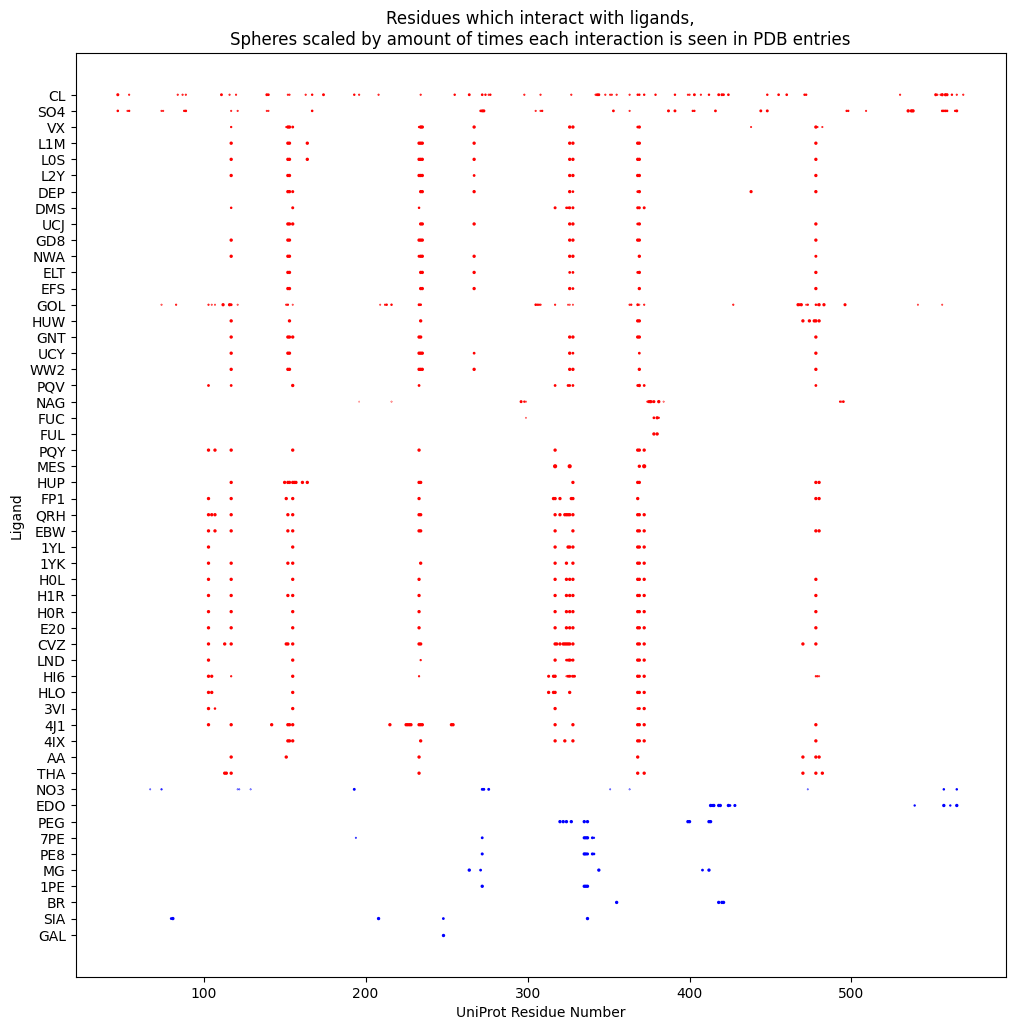

In [26]:
# prepare a figure
plt.rcParams['figure.figsize'] = [12, 12]
fig, ax = plt.subplots()

# plot the less interesting ligands in blue
for ligand in missing_ligands:
    data = df6[df6['ligand_accession'] == ligand]
    data.plot.scatter(x='residue_number', y='ligand_accession', ax=ax, s='interaction_ratio', c='blue')

# plot the interesting ligands in red
for ligand in interesting_ligands:
    data = df6[df6['ligand_accession'] == ligand]
    data.plot.scatter(x='residue_number', y='ligand_accession', ax=ax, s='interaction_ratio', c='red')


plt.ylabel('Ligand')
plt.xlabel('UniProt Residue Number')
plt.title('Residues which interact with ligands,\nSpheres scaled by amount of times each interaction is seen in PDB entries')
plt.show()
plt.close()

It would be interesting to see if the ligands binding to same residues are similar to each other. Let's take any ligand from above interesting ligand dataset and find all the other ligands which are similar to it. 

In the example below, we have taken the neurotoxin VX (HET CODE- VX) and found all the ligands similar to it using "get_similar_ligand_data" function. This function takes ligand name and similarity cutoff (0-1) as arguments. Here we have used similarity cutoff of 0.7 and found all the ligands which are 70 % or more similar to VX. 

In [27]:
ligand_exp = "VX"
similarity_cutoff = 0.7
#finding similar ligands to ligand_exp 
similar_ligands = get_similar_ligand_data(ligand_exp, similarity_cutoff)
sdf=pd.DataFrame(similar_ligands.items(),columns = ['similar_ligand','similarity_score'])
print(sdf)
#find common ligands from similar_ligands and interesting_ligands
common_ligands = [item for item in similar_ligands if item in interesting_ligands]
print(common_ligands)

https://www.ebi.ac.uk/pdbe/graph-api/compound/similarity/VX
  similar_ligand  similarity_score
0            ATJ             0.857
1            CVX             0.778
2            E8W             0.778
3            E9E             0.875
4            EFS             0.750
5             GB             0.714
6            H9A             0.778
7             VR             0.778
['EFS']


Now, you can compare if VX and common_ligands bind to same residues or not and check if similar ligands tend to bind to similar sites.